## Explore MTA Data

In [119]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
#%matplotlib notebook
%matplotlib inline

import csv
from collections import defaultdict
import re

In [58]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

### Useful Functions for Data Standardization

In [59]:
def clean_cols(df):
    for col in df.columns:
        # Clean the string type data
        if df[col].dtype == 'object':
            df[col]= df[col].str.strip()
    return df

def make_standard_names(df):
    # Clean up the column names
    cols = df.columns
    for col in cols:
        col_new = col
        col_new = col_new.lower()
        col_new = col_new.strip()
        col_new = col_new.replace('/','')
        col_new = col_new.replace(' ','_')
        df = df.rename(columns = {col: col_new})
    return df

### NYC Transit Subway Entrance And Exit Data


In [60]:
# This data file provides a variety of information on subway station entrances and exits which includes but is not limited to: 
# Division, Line, Station Name, Longitude and Latitude coordinates of entrances/exits.
nyc_entr_exit = pd.read_csv("https://data.ny.gov/api/views/i9wp-a4ja/rows.csv")

In [61]:
print(nyc_entr_exit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 32 columns):
Division              1868 non-null object
Line                  1868 non-null object
Station Name          1868 non-null object
Station Latitude      1868 non-null float64
Station Longitude     1868 non-null float64
Route1                1868 non-null object
Route2                1020 non-null object
Route3                494 non-null object
Route4                321 non-null object
Route5                238 non-null object
Route6                127 non-null object
Route7                80 non-null object
Route8                48 non-null float64
Route9                28 non-null float64
Route10               23 non-null float64
Route11               23 non-null float64
Entrance Type         1868 non-null object
Entry                 1868 non-null object
Exit Only             56 non-null object
Vending               1868 non-null object
Staffing              1868 non-null object


In [62]:
nyc_entr_exit.sample(5)

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11,Entrance Type,Entry,Exit Only,Vending,Staffing,Staff Hours,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
1165,IND,Fulton,Kingston-Throop,40.680,-73.941,A,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,Throop Ave,Fulton St,NE,40.680,-73.940,"(40.679921, -73.940858)","(40.680010, -73.940247)"
355,IND,8 Avenue,Inwood - 207th St,40.868,-73.920,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,True,NaN,True,Broadway,207th St,SW,40.868,-73.921,"(40.868072, -73.919899)","(40.867653, -73.920949)"
608,BMT,Broadway Jamaica,Van Siclen Av,40.678,-73.892,J,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,Van Siclen Ave,Fulton St,SW,40.678,-73.892,"(40.678024, -73.891688)","(40.677847, -73.891711)"
137,IND,6 Avenue,Bergen St,40.686,-73.991,F,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,Smith St,Bergen St,NE,40.687,-73.990,"(40.686145, -73.990862)","(40.686727, -73.990269)"
804,BMT,Canarsie,Bedford Av,40.717,-73.957,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,Bedford Ave,N 7th St,SE,40.718,-73.958,"(40.717304, -73.956872)","(40.717714, -73.957695)"


### Turnstile Usage Data 2017

Currently openting a single file over a two week period for MTA turnstyle data. To run on local machine, set up paths in the same way, or change the string to appropriate location

In [69]:
### Turnstile Usage Data: 2017
# State of New York — Data file contains information on entry/exit register values for individual control areas.
nyc_turnstile_2017 = pd.read_csv('turnstile_data/turnstile_170617.txt')
#nyc_turnstile_2017 = pd.read_csv("https://data.ny.gov/api/views/v5y5-mwpb/rows.csv")
#nyc_turnstile_2017 = pd.read_csv('turnstile_data/Turnstile_Usage_Data__2017.csv')


### Clean Data and create useful columns

In [189]:
#strip away white space from data and standardize names
#some files have names in all caps, and other do not.
nyc_turnstile_2017 = clean_cols(nyc_turnstile_2017)
nyc_turnstile_2017 = make_standard_names(nyc_turnstile_2017)

#Make a column with real timestamps (date and time)
nyc_turnstile_2017['readtime'] = nyc_turnstile_2017['date'] + ' ' + nyc_turnstile_2017['time']
nyc_turnstile_2017['readtime'] = pd.to_datetime(nyc_turnstile_2017['readtime'], format='%m/%d/%Y %H:%M:%S')

# Create a unique "Meter Name"
# 'ca', 'unit','scp' comprise a unique "meters".
# There can be several "meters" at each station. This these can be recombined using "Group By"
nyc_turnstile_2017['id'] = nyc_turnstile_2017['ca']+'_'+nyc_turnstile_2017['unit']+'_'+nyc_turnstile_2017['scp']
nyc_turnstile_2017['entries_diff'] = nyc_turnstile_2017['entries'].diff()
nyc_turnstile_2017['exits_diff'] = nyc_turnstile_2017['exits'].diff()


Create a Data Frame that is multi-indexed on "id" and time-stamp. This might be overkill, and it might be better to not use multi-indexing

In [191]:
nyc_turnstile_2017_grouped = nyc_turnstile_2017.set_index(['id','readtime'])
nyc_turnstile_2017_grouped

ca  unit       scp        station  \
id                  readtime                                                    
A002_R051_02-00-00  2017-06-10 00:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-10 04:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-10 08:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-10 12:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-10 16:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-10 20:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 00:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 04:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 08:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 12:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 16:00:00   A002  R051  02-00-00          59 ST   
                    2017-06-11 20:00:00   A002  R051  02-00-00          59 ST   
...                                        ...   ...       ...            ...   
TRAM2_R469_00-05-01 2017-06-15 01:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-15 05:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-15 09:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-15 13:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-15 17:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-15 21:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 01:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 05:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 09:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 13:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 17:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   
                    2017-06-16 21:00:00  TRAM2  R469  00-05-01  RIT-ROOSEVELT   

                                        linename division        date  \
id                  readtime                                            
A002_R051_02-00-00  2017-06-10 00:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-10 04:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-10 08:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-10 12:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-10 16:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-10 20:00:00  NQR456W      BMT  06/10/2017   
                    2017-06-11 00:00:00  NQR456W      BMT  06/11/2017   
                    2017-06-11 04:00:00  NQR456W      BMT  06/11/2017   
                    2017-06-11 08:00:00  NQR456W      BMT  06/11/2017   
                    2017-06-11 12:00:00  NQR456W      BMT  06/11/2017   
                    2017-06-11 16:00:00  NQR456W      BMT  06/11/2017   
                    2017-06-11 20:00:00  NQR456W      BMT  06/11/2017   
...                                          ...      ...         ...   
TRAM2_R469_00-05-01 2017-06-15 01:00:00        R      RIT  06/15/2017   
                    2017-06-15 05:00:00        R      RIT  06/15/2017   
                    2017-06-15 09:00:00        R      RIT  06/15/2017   
                    2017-06-15 13:00:00        R      RIT  06/15/2017   
                    2017-06-15 17:00:00        R      RIT  06/15/2017   
                    2017-06-15 21:00:00        R      RIT  06/15/2017   
                    2017-06-16 01:00:00        R      RIT  06/16/2017   
                    2017-06-16 05:00:00        R      RIT  06/16/2017   
                    2017-06-16 09:00:00        R      RIT  06/16/2017   
                    2017-06-16 13:00:00        R      RIT  06/16/2017   
                    2017-06-16 

### Get a unique list of "meters"

In [193]:
total_meters = nyc_turnstile_2017_grouped.index.get_level_values('id').unique()
total_meters

Index(['A002_R051_02-00-00', 'A002_R051_02-00-01', 'A002_R051_02-03-00',
       'A002_R051_02-03-01', 'A002_R051_02-03-02', 'A002_R051_02-03-03',
       'A002_R051_02-03-04', 'A002_R051_02-03-05', 'A002_R051_02-03-06',
       'A002_R051_02-05-00',
       ...
       'TRAM1_R468_00-00-00', 'TRAM1_R468_00-00-01', 'TRAM1_R468_00-00-02',
       'TRAM1_R468_00-05-00', 'TRAM2_R469_00-00-00', 'TRAM2_R469_00-00-01',
       'TRAM2_R469_00-03-00', 'TRAM2_R469_00-03-01', 'TRAM2_R469_00-05-00',
       'TRAM2_R469_00-05-01'],
      dtype='object', name='id', length=4695)

### Pick a random "meter" and plot the results

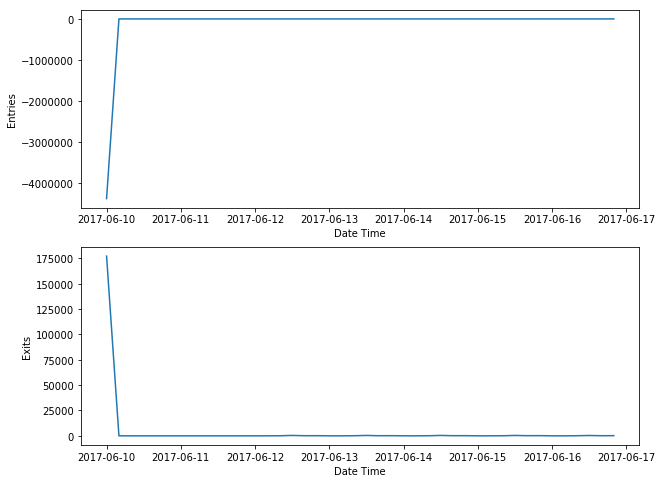

In [194]:
test_turn = random.randint(0,len(total_meters))
total_meters[test_turn]

test_id_df = nyc_turnstile_2017_grouped.loc[
    nyc_turnstile_2017_grouped.index.get_level_values('id')==total_meters[test_turn]]


fig, ax = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Col

ax[0].plot(test_id_df.index.get_level_values('readtime'),test_id_df.entries_diff)
ax[0].set_xlabel('Date Time')
ax[0].set_ylabel('Entries')

ax[1].plot(test_id_df.index.get_level_values('readtime'),test_id_df.exits_diff)
ax[1].set_xlabel('Date Time')
ax[1].set_ylabel('Exits')


### Notes
Clearly the "diff" method breaks down for the first record for each individual meter. For each meter, the first record should be excluded. Other filtering may be necessary once these undesired results are removed.

### Random Stuff

In [45]:
scp_df = nyc_turnstile_2017['scp'].drop_duplicates()
len(scp_df)

230

In [48]:
scp_station_df = nyc_turnstile_2017[['scp','station']]
scp_station_df = scp_station_df.drop_duplicates()
len(scp_station_df)


4149

In [55]:
#Make hierarchical index
three_col = nyc_turnstile_2017[['ca','unit','scp']].drop_duplicates()
len(three_col)

4695

In [12]:
# Calculate entries and exists per period
nyc_turnstile_2017['entries_diff'] = nyc_turnstile_2017['entries'].diff()
nyc_turnstile_2017['exits_diff'] = nyc_turnstile_2017['exits'].diff()

nyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] < 0] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] < 0] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['entries_diff'] > 10**5] = np.nan
nyc_turnstile_2017[nyc_turnstile_2017['exits_diff'] > 10**5] = np.nan

In [50]:
# Make a Datetime Column
nyc_turnstile_2017['dtime'] = nyc_turnstile_2017['date'] + ' ' + nyc_turnstile_2017['time']
nyc_turnstile_2017['dtime'] = pd.to_datetime(nyc_turnstile_2017['dtime'], format='%m/%d/%Y %H:%M:%S')

197209

In [14]:
# plot one sample timeseries
single_station = nyc_turnstile_2017[nyc_turnstile_2017.station == '59 ST']

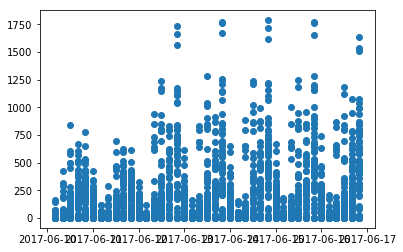

In [15]:
plt.plot(single_station['dtime'],single_station['entries_diff'],marker = 'o',linestyle='None')

In [111]:
nyc_turnstile_2017

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,readtime,id
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,00:00:00,REGULAR,6215258,2104297,2017-06-10 00:00:00,A002_R051_02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,04:00:00,REGULAR,6215284,2104303,2017-06-10 04:00:00,A002_R051_02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,08:00:00,REGULAR,6215318,2104337,2017-06-10 08:00:00,A002_R051_02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,12:00:00,REGULAR,6215475,2104417,2017-06-10 12:00:00,A002_R051_02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,16:00:00,REGULAR,6215841,2104465,2017-06-10 16:00:00,A002_R051_02-00-00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2017,20:00:00,REGULAR,6216274,2104499,2017-06-10 20:00:00,A002_R051_02-00-00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,00:00:00,REGULAR,6216533,2104521,2017-06-11 00:00:00,A002_R051_02-00-00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,04:00:00,REGULAR,6216576,2104531,2017-06-11 04:00:00,A002_R051_02-00-00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,08:00:00,REGULAR,6216600,2104549,2017-06-11 08:00:00,A002_R051_02-00-00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2017,12:00:00,REGULAR,6216706,2104612,2017-06-11 12:00:00,A002_R051_02-00-00


In [17]:
ls turnstile_data/

Turnstile_Usage_Data__2016.csv  turnstile_170617.txt
Turnstile_Usage_Data__2017.csv  turnstile_170624.txt
turnstile_170610.txt
